<a href="https://colab.research.google.com/github/Somertonman/hackathon_2023/blob/main/final_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
%%capture
!pip install python-docx docx

In [2]:
!pip install transformers sacremoses
from transformers import pipeline

qa_pipeline = pipeline("question-answering", "timpal0l/mdeberta-v3-base-squad2")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 37.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.6/880.6 KB 35.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 60.7 MB/s eta 0:00:00
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=dcc77653d9df90a525ca23310054c3c4d5ba11f15b0b43558ba881f7eeb9f178
  Stored in directory: /root/.cache/pip/wheels/82/ab/9b/c15899bf659ba74f623ac776e861cf2eb8608c1825ddec66a4
Successfully built sacremoses


Downloading:   0%|          | 0.00/879 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/453 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/16.3M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/173 [00:00<?, ?B/s]

In [51]:
import pandas as pd
import spacy

from docx import Document
import os
import random
import networkx as nx
import matplotlib.pyplot as plt

from difflib import SequenceMatcher

from tqdm import tqdm
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None

In [4]:
%%capture
!python -m spacy download ru_core_news_lg

In [25]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("russian") 

In [23]:
# %%capture
# !pip install pymorphy2
# import pymorphy2

# Data source

In [5]:
!gdown 1PvIMSFrs7D7rdmObf-x5J90U4Y-sJeud
# Download manually corrected .csv
df = pd.read_csv('/content/normal_position.csv')
df = df[['normal_name', 'normal_position', 'dept']].rename(columns={'normal_name':'name', 'normal_position':'position'})

Downloading...
From: https://drive.google.com/uc?id=1PvIMSFrs7D7rdmObf-x5J90U4Y-sJeud
To: /content/normal_position.csv
100% 26.5k/26.5k [00:00<00:00, 34.0MB/s]


In [6]:
departments = df['dept'].unique()
employees = df['name'].unique()
positions = df['position'].unique()

In [7]:
df.head()

,name,position,dept
0,Абаимов С.,тимлид отдел разработк сист,Отдел разработки систем
1,Абаимов С.,тимлид отдел разработк сист,Отдел разработки систем
2,Абаимов С.,тимлид отдел разработк сист,Отдел разработки систем
3,Абаков А.,архитектор программн обеспечен,Отдел архитектуры
4,Абаков А.,архитектор программн обеспечен,Отдел архитектуры


# Graph

100%|██████████| 120/120 [00:00<00:00, 748.54it/s]


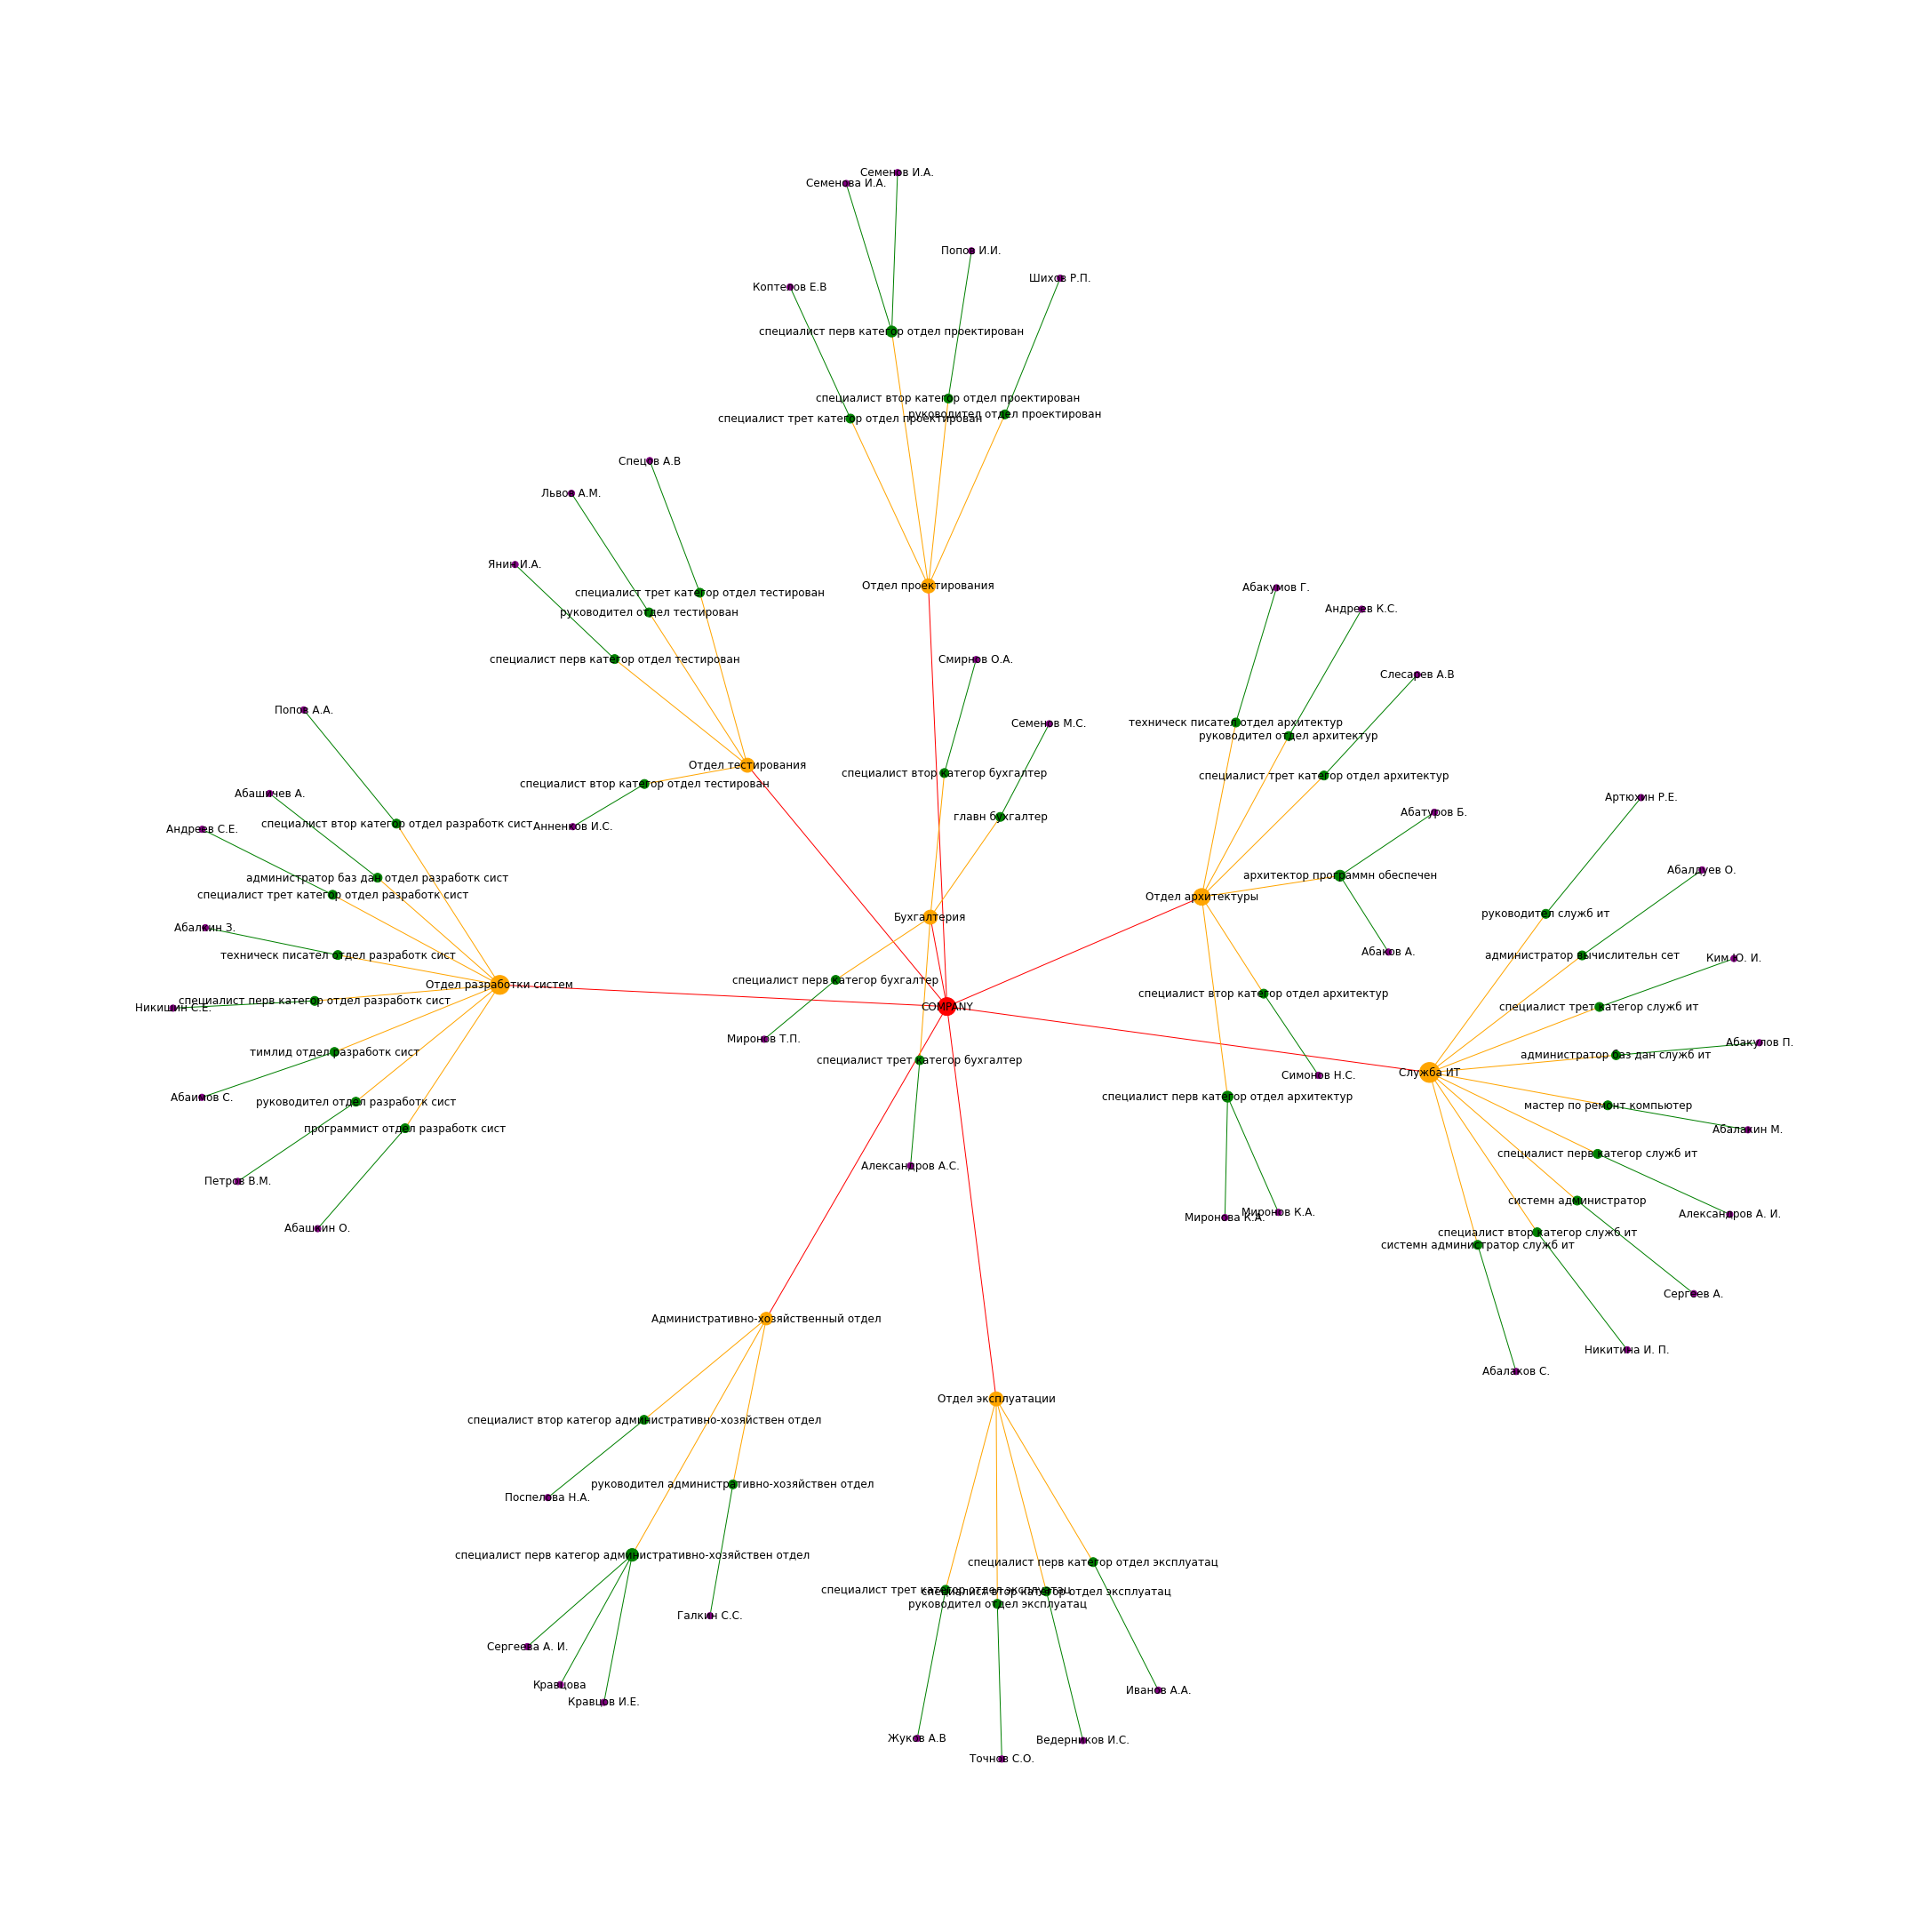

In [11]:
# create a graph object
G = nx.Graph()

comp_name = 'COMPANY'

for z in list(departments):
    G.add_edge(comp_name, z)
    # iterate through the rows of the DataFrame
    for i, row in tqdm(df.iterrows(), total=len(df)):
        # add task_responsibles_groups node
        dept = row["dept"]
        G.add_node(dept, size=df["dept"].value_counts()[dept])
        # add position node
        position = row["position"]
        G.add_node(position, size=df["position"].value_counts()[position])
        # add name node
        name = row["name"]
        G.add_node(name, size=df["name"].value_counts()[name])
        # add edges between task_responsibles_groups and position
        G.add_edge(dept, position)
        # add edges between position and name
        G.add_edge(position, name)

# draw the graph
import matplotlib.pyplot as plt

plt.figure(figsize=(30,30))
pos = nx.spring_layout(G) # spring layout to calculate node positions

# create a list of node sizes
node_sizes = []
for node in G.nodes():
    node_sizes.append(G.degree(node)*50)

# create a list of node colors
node_colors = []
for node in G.nodes():
    if node in departments:
        node_colors.append("orange")
    elif node in df["position"].unique():
        node_colors.append("green")
    elif node in df["name"].unique():
        node_colors.append("purple")
    else:
        node_colors.append("red")

# create a list of edge colors
edge_colors = []
for edge in G.edges():
    if edge[0] in departments:
        edge_colors.append("orange")
    elif edge[0] in df["position"].unique():
        edge_colors.append("green")
    elif edge[0] in df["name"].unique():
        edge_colors.append("purple")
    else:
        edge_colors.append("red")

nx.draw(G, pos, with_labels=True, node_color=node_colors, node_size=node_sizes, edge_color=edge_colors)


## Parsing text from docx files

In [79]:
#получение текста из файла
def get_text(folder_path, filename):
    doc = Document(f'{folder_path}/{filename}')
    fullText = []
    for para in doc.paragraphs:
        fullText.append(para.text)
    return '\n'.join(fullText)

#стемматизация
def Convert(string): 
    li = list(string.split(" ")) 
    return li 

def stem(text):
  my_words = Convert(text)
  l = []
  for word in my_words:
    if word != "специалист":
        l.append(stemmer.stem(word))
  return " ".join(l)

#имена до инициалов
def name_to_initials(full_name):
    if not full_name:
        return ""
    if '.' in full_name:
        return full_name
    name_parts = full_name.split()
    lastname = name_parts[0]
    initials = "".join([part[0] + "." for part in name_parts[1:]])
    return lastname + " " + initials

#Вычленение имен и должностей
def name_position(text):
    doc = nlp(text)
    names = []
    for ent in doc.ents:
        if ent.label_ == "PER":
            names.append(ent.text)

    dict_emp = {}
    for i in names:
        dict_emp[name_to_initials(i.lower()).replace(". ", ".")] = stem(qa_pipeline(f"Какая должность у {i}?", text)['answer'])

    return dict_emp

def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()

def is_name_position_in_graph(G, name, position, precision):
    if not name and not position:
        return False

    for node in G.nodes():
        if name:
            if similar(name, node) >= precision:
                continue
        if position:
            neighbors = G.neighbors(node)
            for neighbor in neighbors:
                if similar(position, neighbor) >= precision:
                    return True
    return False

def average(lst):
    return sum(lst) / len(lst)

In [ ]:
#Нужно сложить все проверяемые файлы в папку "docx"

In [ ]:
#Функция проверки
def proverka(folder_path, precision_sim, precision_itog):
    df = pd.DataFrame(data={'id_doc': [None], 'result_dict': [None], 'result': [None], 'precision_l': [None], 'precision': [None]})
    fin_dict = {}
    for f in os.listdir(folder_path):
        if f.endswith('.docx'):
            text = get_text(folder_path, f)
            name_n_pos = name_position(text)
            fin_dict[f] = name_n_pos
    
    for i in fin_dict:
        mark_l = []
        for z in fin_dict[i]:
            mark = is_name_position_in_graph(G, z, fin_dict[i][z], precision_sim)
            mark_l.append(mark) 

        avg_mark = average(mark_l)
        
        df_one = pd.DataFrame(data={'id_doc': [i], 
                                'result_dict': [fin_dict[i]], 
                                'result': [True if avg_mark >= precision_itog else False], 
                                'precision_l': [mark_l], 
                                'precision': round(avg_mark*100, 2)})

        df = pd.concat([df, df_one])

    return df.reset_index().drop(columns=['index'])[1:]

# Document checker

In [ ]:
from google.colab import files

uploaded = files.upload()

In [91]:
itog = proverka('/content/docx', precision_sim = 0.75, precision_itog = 0.75)
itog

,id_doc,result_dict,result,precision_l,precision
0,None,None,None,None,NaN
1,3.docx,"{'роговцова б.': ' контент менеджер', 'турова ...",False,"[False, True, False, True]",50.0
2,4.docx,{'турова с.': ' администратор вычислительн сет...,True,"[True, True]",100.0
3,1.docx,"{'роговцова б.': ' контент менеджер', 'ерохина...",False,"[False, False]",0.0
4,8.docx,{'поварихина в.': ' специалист по информацион ...,False,"[False, False]",0.0
5,0.docx,{'поварихина в.': ' специалист по информацион ...,False,"[False, True]",50.0
